In [1]:
# I import all the necessary libraries
import pandas as pd
import numpy as np
from PIL import Image
import os
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, RandomFlip, RandomRotation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
from tf_explain.callbacks.grad_cam import GradCAM
import tensorflow as tf
from keras.applications import VGG16
from keras.models import Model

## 1) The Dataset

- Assuming you have a classification problem, is it binary, multi-class or multi-label?
    Binary

- Show a few examples per class


- How many classes?
    Two

- How many images per class?
    262 civilian 289 soldier

- Train/Test sizes
    551 train 56 train

- Image size?
    64 by 64

- How are the images labeled?
    Soldier and Civilian

- Dataset source(s)?
    Imsitu dataset, Google

In [2]:
# I create a variable that contains the the path to the training set
image_dir = "C:/Users/Dániel/Desktop/BUas/Year 1 Block C/ImsituDataset/Train"

# I set what size the images will be
width = 64
height = 64

# I create lists to hold the training data
X_train = []
Y_train = []

# I iterate over the pictures
for filename in os.listdir(image_dir):
    # I make sure that the file is a jpg
    if filename.endswith(".jpg"):
        # I open the image with PIL
        image = Image.open(os.path.join(image_dir, filename))
        # I resize the images to what I set before
        image = image.resize((width, height))
        # I convert image to a numpy array
        image_data = np.array(image)
        # I append the image data to X_train
        X_train.append(image_data)
        # I extract the label from the filename
        label = filename.split(" ")[0]
        # I set the target variable "soldier" to number 1 and the rest to 0
        if label == "soldier":
            label = 1
        else:
            label = 0
        # I append the label to Y_train
        Y_train.append(label)

# I convert the lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
#[1]

In [3]:
# I create a variable that contains the the path to the test set
image_dir = "C:/Users/Dániel/Desktop/BUas/Year 1 Block C/ImsituDataset/Test"

# I create lists to hold the training data
X_test = []
Y_test = []

# I iterate over the pictures
for filename in os.listdir(image_dir):
    # I make sure that the file is a jpg
    if filename.endswith(".jpg"):
        # I open the image with PIL
        image = Image.open(os.path.join(image_dir, filename))
        # I resize the images to what I set before
        image = image.resize((width, height))
        # I convert image to a numpy array
        image_data = np.array(image)
        # I append the image data to X_test
        X_test.append(image_data)
        # I extract the label from the filename
        label = filename.split(" ")[0]
        if label == "soldier":
            label = 1
        else:
            label = 0
        # I append the label to Y_test
        Y_test.append(label)

# I convert the lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)
#[2]

In [4]:
# I print the shapes of the variables to check if everythnig is correct
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((551, 64, 64, 3), (56, 64, 64, 3), (551,), (56,))

## 3) Preprocessing

I did not have to do too much preprocessing, because I could only use 1:1 pictures thanks to the IMSITU dataset, therefore I only looked for these ones on Google with the special search, but I did have to occasionally delete wrong file formats. After loading them in I downgraded their sizes to 64 by 64, then normalized them.

In [5]:
# I do data augmentation to have more data, since I only have a small dataset
data_augmentation = Sequential([RandomFlip(mode='horizontal'), RandomRotation(0.1)])

# I define the model as sequential
model = Sequential()

# I apply the data augmentation
data_augmentation

#I add a convolutional layer with padding
model.add(Conv2D(64, (3, 3), input_shape=(64, 64, 3), activation='relu', padding="same", strides=1))
model.add(MaxPooling2D(pool_size=(2,2)))

# I add another convolutional layer with padding
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", strides=1))
model.add(MaxPooling2D(pool_size=(2,2)))

# I do batch normalization
model.add(BatchNormalization())

# I flatten the image data so that it can be processed by the neural network
model.add(Flatten())

# I add two dense layers with relu activation
model.add(Dense(64, activation='relu'))
model.add(Dense(48, activation='relu'))

# I add a dropout layer to help against overfitting
model.add(Dropout(0.25))

# I add a final output layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# I define the optmizer as Adam, with a learning rate of 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# I compile the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [6]:
# I do transfer learning
def build_transfer_model(print_summary=False):
    # I load the pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

    # I freeze the pre-trained layers so they're not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # I add new layers on top of pre-trained model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # I create the new model
    model_t = Model(inputs=base_model.input, outputs=predictions)

    return model_t

model_t = build_transfer_model()
#[3]

## 4) CNN architecture

In [7]:
# I print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                      

## 5) CNN training

- Loss function: binary_crossentropy

- Optimizer (with its hyper-parameters): Adam with a learning rate of 0.0001

- Metrics: Accuracy

- Learning curves: Below

In [8]:
# I define a variable to hold early stopping and model checkpoint that both follow validation accuarcy
callbacks = [EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True), 
             ModelCheckpoint('best_weights.hdf5', monitor = 'val_accuracy', save_best_only = True)]

# I create a variable to hold he history of the training, and fit the model
# I only use model checkpoint from callbacks, but I leave it so that it can be changed to also use early stopping
H = model.fit(X_train, Y_train, batch_size=32, epochs=12, validation_data=(X_test, Y_test), callbacks=callbacks[1])

Epoch 1/12
18/18 [==============================] - 4s 156ms/step - loss: 0.6827 - accuracy: 0.6207 - val_loss: 3.6546 - val_accuracy: 0.5357
Epoch 2/12
18/18 [==============================] - 3s 154ms/step - loss: 0.4666 - accuracy: 0.7822 - val_loss: 2.2346 - val_accuracy: 0.5714
Epoch 3/12
18/18 [==============================] - 3s 143ms/step - loss: 0.3156 - accuracy: 0.8693 - val_loss: 1.6001 - val_accuracy: 0.5893
Epoch 4/12
18/18 [==============================] - 3s 166ms/step - loss: 0.2389 - accuracy: 0.9238 - val_loss: 1.0985 - val_accuracy: 0.6071
Epoch 5/12
18/18 [==============================] - 3s 154ms/step - loss: 0.1776 - accuracy: 0.9401 - val_loss: 0.5695 - val_accuracy: 0.7857
Epoch 6/12
18/18 [==============================] - 3s 150ms/step - loss: 0.1467 - accuracy: 0.9583 - val_loss: 0.4277 - val_accuracy: 0.7321
Epoch 7/12
18/18 [==============================] - 3s 159ms/step - loss: 0.0924 - accuracy: 0.9837 - val_loss: 0.3915 - val_accuracy: 0.8036
Epoch 

## 6) Model performance

Metrics plots

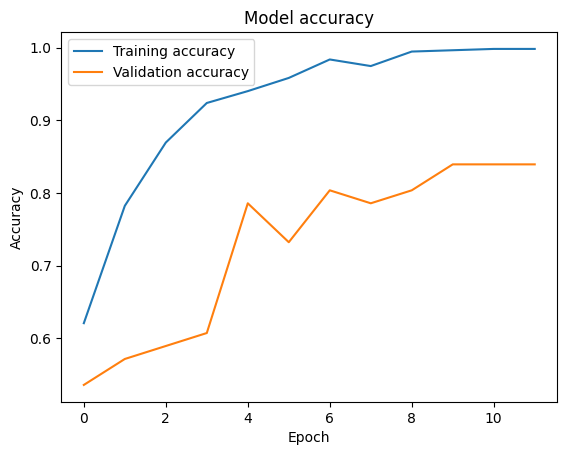

In [9]:
# I plot model accuracy
plt.plot(H.history['accuracy'], label= 'Training accuracy')
plt.plot(H.history['val_accuracy'], label= 'Validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

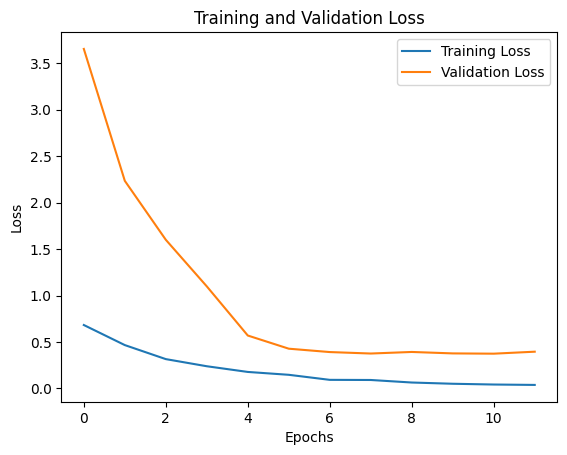

In [10]:
# I plot model loss
plt.figure()
plt.plot(H.history['loss'], label= 'Training Loss')
plt.plot(H.history['val_loss'], label= 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# I load the best weights and evaluate the test set
model.load_weights('best_weights.hdf5')
model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 26ms/step - loss: 0.3771 - accuracy: 0.8393


[0.3771021366119385, 0.8392857313156128]

## 7) Error analysis

Top error interpretation

2/2 [==============================] - 0s 23ms/step


C:\Users\Dániel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


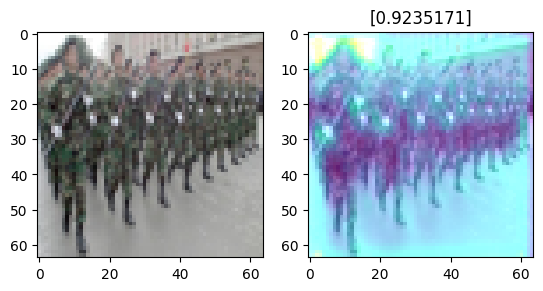

In [12]:
# I create an instance of GradCAM
gradcam = GradCAM()

# I choose a picture from the test set
v = 34

# I plot the image, the GradCAM heatmap for the chosen image, the confidence with which it is predicted
img = X_test[v]
img = np.reshape(img, (1, 64, 64, 3))
heatmap = gradcam.explain((img, None), model, class_index=0, layer_name='conv2d_1')
img = np.reshape(img, (64, 64, 3))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(heatmap)
plt.title(model.predict(X_test)[v])
plt.show()

18/18 [==============================] - 1s 40ms/step


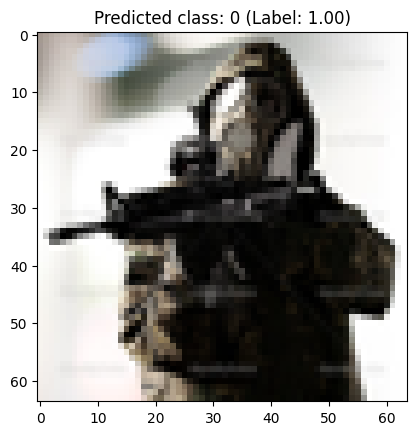

In [13]:
# I find the worst prediction
y_pred = model.predict(X_train)
diff = y_pred - Y_train

bad_index = np.where(diff == np.amax(diff))
worst_index = bad_index[0][0]

# I plot it with the label
plt.imshow(X_train[worst_index])
predicted_class = np.argmax(y_pred[worst_index])
label = y_pred[worst_index][predicted_class]
plt.title(f"Predicted class: {predicted_class} (Label: {label:.2f})")
plt.show()
[4]

In [14]:
# I create a variable with the location of a picture that I want to see
IMG_dir = "C:/Users/Dániel/Desktop/BUas/Year 1 Block C/ImsituDataset/Test/civilian (13).jpg"

# I load the image and turn it into an array
img = tf.keras.preprocessing.image.load_img(IMG_dir, target_size=(64, 64, 3))
img = tf.keras.preprocessing.image.img_to_array(img)

In [15]:
# I create the input in a format that the explainer expects
input_img = (np.array([img]), None)

# I initialize the explainer as an instance of the GradCAM object
explainer = GradCAM()

# I obtain explanations for the image using GradCAM
print("Input shape:", input_img[0].shape)
grid = explainer.explain(input_img,
                         model,
                         class_index=0
                         )
print("Output shape:", grid.shape)

# I save the output image
explainer.save(grid, "./outputs/explain/", "grad_cam_soldat.png")

Input shape: (1, 64, 64, 3)
Output shape: (64, 64, 3)


In [16]:
# I define a function that calculates the disparate impact
def disparate_impact(y_true, y_pred, sensitive_features):
    # I group the data by sensitive feature and compute the positive outcome rate for each group
    groups = np.unique(sensitive_features)
    pos_rate = {}
    for group in groups:
        indices = np.where(sensitive_features == group)[0]
        pos_rate[group] = np.mean(y_pred[indices])

    # I compute the disparate impact
    di = pos_rate[groups[0]] / pos_rate[groups[1]]

    return di


In [17]:
# I compute the disparate impact on the test set
sensitive_features = (Y_test == 1)
di = disparate_impact(Y_test, y_pred, sensitive_features)
print("Disparate impact: {:.3f}".format(di))
[5]

Disparate impact: 1.473


# Reference list
* [1] ChatGPT, OpenAI, I rewrote it many times since, 'Write me a code that loads pictures in to Python', 03-2023
* [2] ChatGPT, OpenAI, I rewrote it many times since, 'Write me a code that loads pictures in to Python', 03-2023
* [3] ChatGPT, OpenAI, I rewrote it to fit into my code, 'write me a code that does transfer learning for a binary classification with pictures', 03-2023
* [4] ChatGPT, OpenAI, I rewrote it to fit into my code, 'Write me a code that finds the worst predicton in a binary classification CNN with pictures, and prints it with the predicted class and original label', 04-2023
* [5] ChatGPT, OpenAI, I rewrote it to fit into my code, 'Write me a Python function that returns an appropriate fairness metric, and corresponding calculation', 05-04-2023